# Medical Image Classification: Hello World Deep Learning Tutorial

### Prepare data using the MD.ai python client, train using fast.ai 

This is a high-level introduction into practical machine learning for purposes of medical image classification. The goal of this tutorial is to build a deep learning classifier to accurately differentiate between chest and abdominal X-rays. The model is trained using 75 images de-identified images obtained from Open-i.

Original github repo this is based on: https://github.com/ImagingInformatics/machine-learning

MD.ai annotator project URL: https://public.md.ai/annotator/project/PVq9raBJ

**How to use on Colab: in the menu, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.**

In [1]:
# fast.ai setup
!git clone https://github.com/fastai/fastai.git
import os
os.chdir("fastai")
!git pull

fatal: destination path 'fastai' already exists and is not an empty directory.
Already up to date.


In [2]:
os.chdir("..")
!pip install -q https://github.com/fastai/fastai/archive/master.zip

In [3]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [4]:
!pip install -q ipywidgets==6.0.0

In [5]:
import pydicom
import os 
import sys

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [6]:
!pip install --upgrade --quiet --no-cache mdai

### Note that version 0.04 or above is required

In [ ]:
import mdai
mdai.__version__

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [9]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="")

Successfully authenticated to public.md.ai.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `PVq9raBJ` for `https://public.md.ai/annotator/project/PVq9raBJ`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [10]:
p = mdai_client.project('PVq9raBJ', path='/data/HelloWorld')

Using path '/data/HelloWorld' for data.
Preparing annotations export for project PVq9raBJ...                                                
Preparing images export for project PVq9raBJ...                                                     
Using cached annotations data for project PVq9raBJ.
Using cached images data for project PVq9raBJ.


### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [11]:
p.show_label_groups()

Label Group, Id: G_3lv, Name: Default group
	Labels:
	Id: L_yxv, Name: Abdomen
	Id: L_dyy, Name: Chest



In [12]:
# this maps label ids to class ids as a dict obj
labels_dict = {'L_yxv':0, # Abdomen 
               'L_dyy':1, # Chest  
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_yxv': 0, 'L_dyy': 1}


### Create the *Training* and *Validation* datasets

In [13]:
p.show_datasets() 

Datasets:
Id: D_33v, Name: TRAIN
Id: D_vvp, Name: VAL
Id: D_oz1, Name: TEST



In [14]:
# create training dataset 
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare() 
image_ids_train  = train_dataset.get_image_ids()

# create the validation dataset 
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
image_ids_val = val_dataset.get_image_ids()

### Load fast.ai library 

In [15]:
# Load libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.conv_learner import *
import seaborn as sns; sns.set(); sns.set_style('white')

### Extract labels (class id)

In [16]:
def get_y(dataset, plot=False):
    ys = [] 
    for img in dataset.get_image_ids(): 
        
        if plot == True: 
            ds = pydicom.read_file(img)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)

            plt.figure() 
            plt.imshow(image)
            
        ann = dataset.imgs_anns_dict[img][0]
        y = dataset.classes_dict[ann["labelId"]]['class_id']
        ys.append(y)
    return ys

In [17]:
y_train = get_y(train_dataset)
y_val = get_y(val_dataset)

## Set model hyperparameters

In [19]:
IMG_PATH = '.'              # not used 
sz = 224                    # resize images
arch = resnet50             # backbone architecture 
bs = 5                      # batch size 

### Setup a DICOM Files Dataset object to be used with fast.ai lib

In [18]:
classes=('Abdomen', 'Chest')

class DicomFilesDataset(FilesDataset):

    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    
    def get_x(self, i): 
        fp = self.fnames[i] 
        ds = pydicom.dcmread(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    
    def get_c(self):
        return len(classes)
    
    def get_y(self, i):
        return self.y[i]

In [20]:
tfms = tfms_from_model(arch, sz, max_zoom=1.1)

# Note that image ids and y (labels) are passed in 
datasets = ImageData.get_ds(DicomFilesDataset, (image_ids_train,y_train),(image_ids_val,y_val), tfms=tfms, path=IMG_PATH)
data = ImageData(IMG_PATH, datasets, bs, num_workers=16, classes=classes)

In [21]:
learn = ConvLearner.pretrained(arch, data)
%time learn.fit(1e-2, 10)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy                  
    0      0.48535    0.102031   0.9       
    1      0.324467   0.131602   0.9                       
    2      0.360629   0.003175   1.0                       
    3      0.327756   0.002439   1.0                       
    4      0.272202   0.003079   1.0                       
    5      0.229836   0.012019   1.0                       
    6      0.241499   0.140408   0.9                       
    7      0.221225   0.002811   1.0                       
    8      0.252596   0.002309   1.0                       
    9      0.420012   0.003838   1.0                       

CPU times: user 8min 6s, sys: 10.2 s, total: 8min 17s
Wall time: 2min 2s


[array([0.00384]), 1.0]

In [22]:
%time log_preds,y = learn.TTA()
# metrics.log_loss(y, np.exp(log_preds)), accuracy(log_preds,y)
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs,y)

CPU times: user 31.1 s, sys: 672 ms, total: 31.7 s
Wall time: 8.08 s


1.0

### Plot images and their predictions 

In [23]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): 
    ds = pydicom.read_file(ds.fnames[idx])
    image = ds.pixel_array
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
    return image
    
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    out_probs = [probs[x].argmax(axis=-1) for x in idxs]
    preds = ['Abdomen' if prob == 0 else 'Chest' for prob in out_probs]
    return plots(imgs, rows=1, titles=preds, figsize=(16,8))

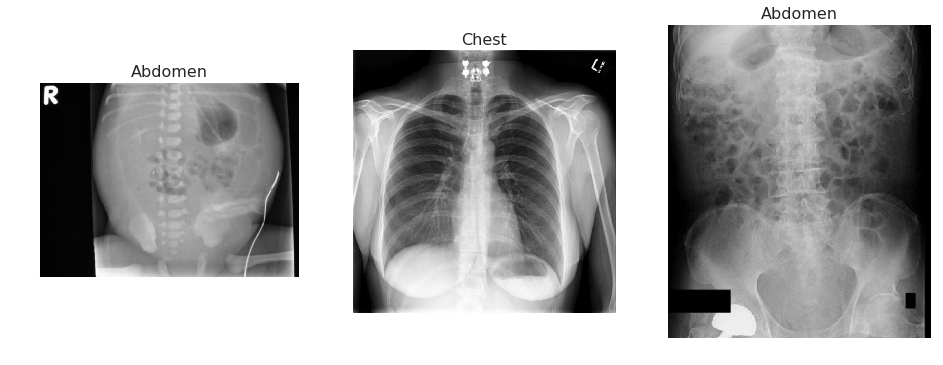

In [25]:
plot_val_with_title(set([random.randint(0,data.val_ds.n-1) for p in range(4)]), "Examples")